In [1]:
! pip install fpdf

  Preparing metadata (setup.py) ... - \ done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40703 sha256=e223ff0c6812913d00e73815781a94c57f4d7c9bcec5034d40bb4e578c6cfdd2
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [2]:
!pip install wikipedia

  Preparing metadata (setup.py) ... - done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=700fed647c99591e4b4e09632fcbb88aabcc638576704cbc6823d91cad258fe5
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [3]:
# Import libraries
import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from fpdf import FPDF
import nltk
from nltk.corpus import stopwords

2024-05-21 18:31:02.537211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 18:31:02.537372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 18:31:02.691614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Function to clean sentences
def clean_sentences(sentence):
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence)  # for URLs
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence)  # HTML tags
    sentence = re.sub(r"[^\w\s]", " ", sentence)  # Removing Punctuation
    sentence = re.sub(r"\w*\d\w*", " ", sentence)  # Removing words that have numbers
    sentence = re.sub(r"[0-9]+", " ", sentence)  # Removing Digits
    sentence = re.sub(r"\s+", " ", sentence).strip()  # Cleaning white spaces
    sentence = sentence.lower()
    words = check_stopwords(sentence)
    return " ".join(words)

# Function to remove stopwords
def check_stopwords(sentence):
    final_sentence=[]
    for word in sentence.split():
        if word not in stop_words:
            final_sentence.append(word)
    return final_sentence

# Function to generate text predictions
def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Function to create PDF report
def create_pdf_report(model_type, history, predicted_text, conclusion):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Summary and Conclusions", ln=True, align='C')
    pdf.cell(200, 10, txt="", ln=True, align='C')  # Add blank line
    pdf.cell(200, 10, txt=f"Model Type: {model_type}", ln=True, align='L')
    pdf.cell(200, 10, txt="", ln=True, align='L')  # Add blank line
    pdf.cell(200, 10, txt="Training and Validation Accuracy Plot", ln=True, align='L')
    plot_training_history(history, 'accuracy', f'{model_type}_accuracy_plot.png')
    pdf.image(f'{model_type}_accuracy_plot.png', x=10, y=pdf.get_y() + 10, w=180)
    pdf.cell(200, 10, txt="", ln=True, align='L')  # Add blank line
    pdf.cell(200, 10, txt="Training and Validation Loss Plot", ln=True, align='L')
    plot_training_history(history, 'loss', f'{model_type}_loss_plot.png')
    pdf.image(f'{model_type}_loss_plot.png', x=10, y=pdf.get_y() + 10, w=180)
    pdf.cell(200, 10, txt="", ln=True, align='L')  # Add blank line
    pdf.cell(200, 10, txt="Predicted Text:", ln=True, align='L')
    pdf.multi_cell(200, 10, txt=predicted_text, align='L')  # Use multi_cell for predicted text
    pdf.cell(200, 10, txt="", ln=True, align='L')  # Add blank line
    pdf.cell(200, 10, txt="Conclusions:", ln=True, align='L')
    pdf.multi_cell(200, 10, txt=conclusion, align='L')  # Use multi_cell for conclusions
    pdf.output(f"{model_type}_summary.pdf")

# Preprocess the data for character-level tokenization
def preprocess_char_level(data):
    cleaned_text = clean_sentences(data.lower())
    return cleaned_text
# Preprocess the data for word-level tokenization
def preprocess_word_level(data):
    cleaned_text = clean_sentences(data.lower())
    return cleaned_text
# Function to plot training history
def plot_training_history(history, metric, filename):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(filename)
    plt.close()


In [5]:
# Load Data
topic = "Artificial Intelligence"
summary = wikipedia.summary(topic)

In [6]:
stop_words = set(stopwords.words('english'))
cleaned_text_char = preprocess_char_level(summary)
cleaned_text_word = preprocess_word_level(summary)
# Split data into training and testing sets
X_train_char, X_test_char = train_test_split([cleaned_text_char]*2, test_size=0.1, random_state=42)
X_train_word, X_test_word = train_test_split([cleaned_text_word]*2, test_size=0.1, random_state=42)

In [7]:
# Tokenize the text for character-level model
tokenizer_char = Tokenizer(char_level=True)
tokenizer_char.fit_on_texts(X_train_char)
sequences_train_char = tokenizer_char.texts_to_sequences(X_train_char)
sequences_test_char = tokenizer_char.texts_to_sequences(X_test_char)
vocab_size_char = len(tokenizer_char.word_index) + 1

# Tokenize the text for word-level model
tokenizer_word = Tokenizer()
tokenizer_word.fit_on_texts(X_train_word)
sequences_train_word = tokenizer_word.texts_to_sequences(X_train_word)
sequences_test_word = tokenizer_word.texts_to_sequences(X_test_word)
vocab_size_word = len(tokenizer_word.word_index) + 1

In [8]:
# Vectorize the data for character-level model
max_len_char = max([len(seq) for seq in sequences_train_char])
X_train_char = pad_sequences(sequences_train_char, maxlen=max_len_char, padding='pre')
X_test_char = pad_sequences(sequences_test_char, maxlen=max_len_char, padding='pre')

# Vectorize the data for word-level model
max_len_word = 40
X_train_word = pad_sequences(sequences_train_word, maxlen=max_len_word, padding='pre')
X_test_word = pad_sequences(sequences_test_word, maxlen=max_len_word, padding='pre')

In [9]:
# Split sequences into input and output for character-level model
y_train_char = X_train_char[:, -1]
y_test_char = X_test_char[:, -1]
X_train_char, y_train_char = X_train_char[:, :-1], tf.keras.utils.to_categorical(y_train_char, num_classes=vocab_size_char)
X_test_char, y_test_char = X_test_char[:, :-1], tf.keras.utils.to_categorical(y_test_char, num_classes=vocab_size_char)

# Split sequences into input and output for word-level model
y_train_word = X_train_word[:, -1]
y_test_word = X_test_word[:, -1]
X_train_word, y_train_word = X_train_word[:, :-1], tf.keras.utils.to_categorical(y_train_word, num_classes=vocab_size_word)
X_test_word, y_test_word = X_test_word[:, :-1], tf.keras.utils.to_categorical(y_test_word, num_classes=vocab_size_word)

In [10]:
# Build the character-based RNN model
model_char = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size_char, output_dim=64, input_length=max_len_char-1),
    tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(128), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size_char, activation='softmax')
])

model_char.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the character-based RNN model
history_char = model_char.fit(X_train_char, y_train_char, epochs=30, validation_data=(X_test_char, y_test_char), verbose=2)

# Generate text predictions for character-based model
seed_text_char = "artificial intelligence"
predicted_text_char = generate_text(seed_text_char, 50, model_char, tokenizer_char, max_len_char)
print("Generated Text (Character-based):", predicted_text_char)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 - 6s - 6s/step - accuracy: 0.0000e+00 - loss: 3.6131 - val_accuracy: 1.0000 - val_loss: 1.4065
Epoch 2/30
1/1 - 2s - 2s/step - accuracy: 1.0000 - loss: 1.6785 - val_accuracy: 1.0000 - val_loss: 1.1524
Epoch 3/30
1/1 - 2s - 2s/step - accuracy: 1.0000 - loss: 1.8346 - val_accuracy: 1.0000 - val_loss: 1.4478
Epoch 4/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - loss: 1.8307 - val_accuracy: 1.0000 - val_loss: 0.3518
Epoch 5/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - loss: 0.4725 - val_accuracy: 1.0000 - val_loss: 0.3775
Epoch 6/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - loss: 0.2649 - val_accuracy: 1.0000 - val_loss: 0.2554
Epoch 7/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - loss: 0.2524 - val_accuracy: 1.0000 - val_loss: 0.1922
Epoch 8/30
1/1 - 2s - 2s/step - accuracy: 1.0000 - loss: 0.4797 - val_accuracy: 1.0000 - val_loss: 0.1537
Epoch 9/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - loss: 0.1799 - val_accuracy: 1.0000 - val_loss: 0.1148
Epoch 10/30
1/1 - 3s - 3s/step - accuracy: 1.0000 - l

In [11]:
# Build the word-based RNN model
model_word = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size_word, output_dim=64, input_length=max_len_word-1),
    tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(128), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size_word, activation='softmax')
])
model_word.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the word-based RNN model
history_word = model_word.fit(X_train_word, y_train_word, epochs=30, validation_data=(X_test_word, y_test_word), verbose=2)

# Generate text predictions for word-based model
seed_text_word = "artificial intelligence"
predicted_text_word = generate_text(seed_text_word, 50, model_word, tokenizer_word, max_len_word)
print("Generated Text (Word-based):", predicted_text_word)

Epoch 1/30
1/1 - 4s - 4s/step - accuracy: 0.0000e+00 - loss: 5.4884 - val_accuracy: 1.0000 - val_loss: 3.7091
Epoch 2/30
1/1 - 0s - 214ms/step - accuracy: 1.0000 - loss: 3.6317 - val_accuracy: 1.0000 - val_loss: 2.7665
Epoch 3/30
1/1 - 0s - 65ms/step - accuracy: 1.0000 - loss: 2.9153 - val_accuracy: 1.0000 - val_loss: 2.0326
Epoch 4/30
1/1 - 0s - 61ms/step - accuracy: 1.0000 - loss: 1.7809 - val_accuracy: 1.0000 - val_loss: 1.5001
Epoch 5/30
1/1 - 0s - 66ms/step - accuracy: 1.0000 - loss: 1.5002 - val_accuracy: 1.0000 - val_loss: 1.0849
Epoch 6/30
1/1 - 0s - 79ms/step - accuracy: 1.0000 - loss: 1.0134 - val_accuracy: 1.0000 - val_loss: 0.7770
Epoch 7/30
1/1 - 0s - 123ms/step - accuracy: 1.0000 - loss: 0.8424 - val_accuracy: 1.0000 - val_loss: 0.5342
Epoch 8/30
1/1 - 0s - 64ms/step - accuracy: 1.0000 - loss: 0.5274 - val_accuracy: 1.0000 - val_loss: 0.3636
Epoch 9/30
1/1 - 0s - 154ms/step - accuracy: 1.0000 - loss: 0.5268 - val_accuracy: 1.0000 - val_loss: 0.2512
Epoch 10/30
1/1 - 0s - 

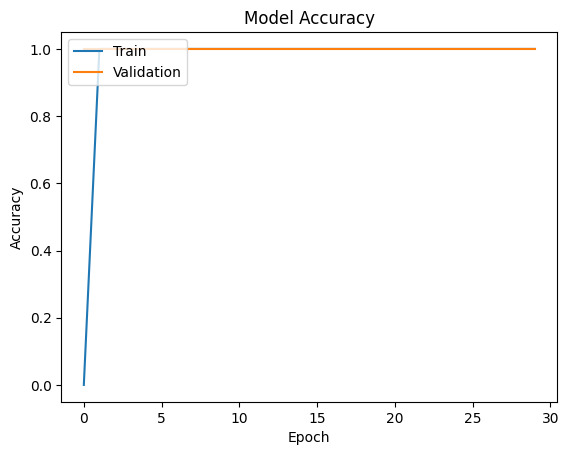

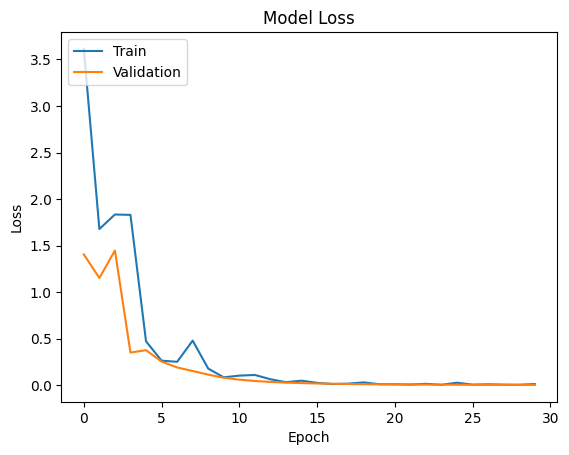

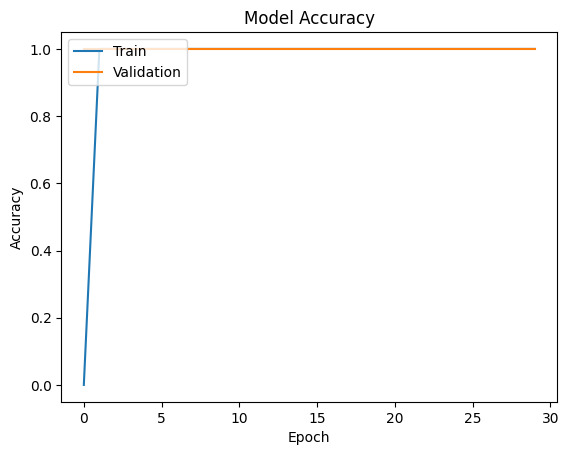

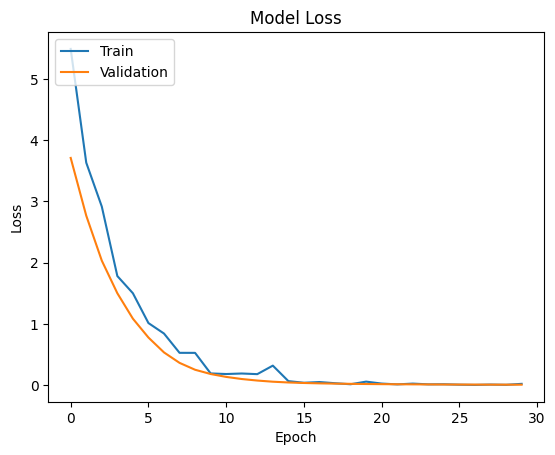

In [12]:
# Create PDF Report
conclusion_char = "The character-based model performed well in generating text predictions based on the provided seed text. " \
               "Further tuning and experimentation could potentially improve its performance."

conclusion_word = "The word-based model also showed promising results in generating text predictions. " \
               "With additional training data and fine-tuning, its performance can be further improved."

create_pdf_report("Character-based", history_char, predicted_text_char, conclusion_char)
create_pdf_report("Word-based", history_word, predicted_text_word, conclusion_word)